# Examples of Simplicial Complexes

Here are some examples to illustrate some definitions in class.

In [18]:
import numpy as np
import bats
from bats.visualization.plotly import ScatterVisualization
import scipy.spatial.distance as distance
import plotly
import plotly.express as px
import matplotlib.pyplot as plt

np.random.seed(0)

## Vietoris-Rips Complex

We saw this construction on the first day of class.  First, we obtain a point sample

In [19]:
def gen_fig_8(n, r=1.0, sigma=0.1):
    X = np.random.randn(n,2)
    X = r * X / np.linalg.norm(X, axis=1).reshape(-1,1)
    X += sigma*np.random.randn(n, 2) + np.random.choice([-1/np.sqrt(2),1/np.sqrt(2)], size=(n,1))
    return X

n = 200
X = gen_fig_8(n)

fig = px.scatter(x = X[:,0], y=X[:,1], width=600, height=600)
fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.write_image("images/03/sample_0.pdf")
fig.show()

To create a Vietoris-Rips complex, we need to specify:
1. A way to compute pairwise distances between points (e.g. a distance matrix)
2. A threshold parameter
3. The maximum dimension of simplex to create

In practice, we don't create high dimensional simplices in the Rips complexes, hence point 3 above.  If we restrict ourselves to the $k$-simplices, there are $k+1$ points needed to define a $k$-simplex.  Thus, the total possible number of $k$-simplices is $\binom{n}{k+1} = O(n^{k+1})$.  The total number of possible simplices of any dimension is $n! = O(n^n)$ (or more informatively $\omega(n^{\lambda n}$ for any $0\le \lambda < 1$).  For small threshold parameters, things may not be too bad, but you'll quickly run out of memory on your computer if you're not careful.

In [20]:
pdist = distance.squareform(distance.pdist(X, 'euclidean'))

R = bats.RipsComplex(bats.Matrix(pdist), 0.5, 2) # connect points within distance 0.5
fig = ScatterVisualization(R, pos=X)
fig.update_layout(width=600, height=600, showlegend=False, margin=dict(l=0, r=0, t=0, b=0))
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.write_image("images/03/sample_0.5.pdf")
fig.show()

In [21]:
for k in range(R.maxdim() + 1):
    print("{}\t {}-simplices".format(R.ncells(k), k))

200	 0-simplices
1907	 1-simplices
9508	 2-simplices


You can use any notion of dissimilarity you would like to form a Vietoris-Rips complex.  You're not limited to the Euclidean metric (or even metrics i.e. with triangle inequality, although you do want $d(x,y) \ge 0$ and $d(x,y) = d(y,x)$.  More generally, you might just call a non-metric construction a flag complex.

Here's an example on our above point cloud using the L1 metric (or `cityblock` metric in scipy)

In [22]:
pdist = distance.squareform(distance.pdist(X, 'cityblock'))

R = bats.RipsComplex(bats.Matrix(pdist), 0.5, 2) # connect points within distance 0.5
fig = ScatterVisualization(R, pos=X)
fig.update_layout(width=600, height=600, showlegend=False, margin=dict(l=0, r=0, t=0, b=0))
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.write_image("images/03/sample_0.5_l1.pdf")
fig.show()

In [23]:
for k in range(R.maxdim() + 1):
    print("{}\t {}-simplices".format(R.ncells(k), k))

200	 0-simplices
1394	 1-simplices
5034	 2-simplices


We see that the complexes are not quite the same - we don't form the top loop in this case.

## Images

Let's go back to our example from day 1.

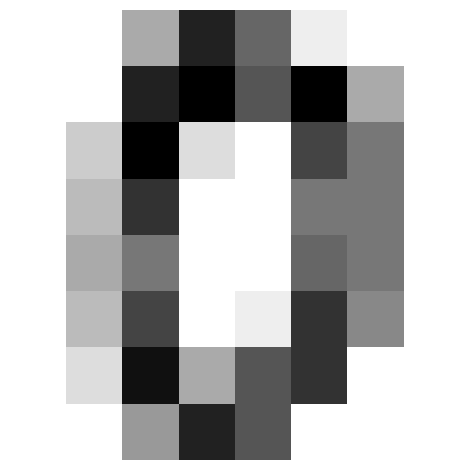

In [14]:
from sklearn import datasets

digits = datasets.load_digits()
image = digits.images[0]

plt.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
plt.axis('off')
plt.tight_layout()
plt.savefig("images/03/zero_img.pdf")
plt.show()

We can obtain simplicial complexes from images by triangulating a pixel grid.  This is easy to achieve using the Freudenthal triangulation, which adds edges $(i,j)\to (i+1,j)$, $(i,j)\to (i,j+1)$ and $(i,j)\to (i+1,j+1)$.

In [24]:
print("image is {} x {}".format(*image.shape))
X = bats.Freudenthal(*image.shape)
for k in range(X.maxdim() + 1):
    print("{}\t {}-simplices".format(X.ncells(k), k))

image is 8 x 8
64	 0-simplices
161	 1-simplices
98	 2-simplices


We can map these simplices back to the grid

In [37]:
# compute position of points
posX, posY = np.meshgrid(range(image.shape[0]), range(image.shape[1]))
pos = np.stack((posX.flatten(), posY.flatten())).T
fig = ScatterVisualization(X, pos=pos)
fig.update_layout(width=300, height=300, showlegend=False, margin=dict(l=0, r=0, t=0, b=0))
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.write_image("images/03/freudenthal.pdf")
fig.show()

Let's take a look at a super-level set of the image we created. We'll do this by reversing the pixel intensities and looking at sub-level sets

In [42]:
image = image.max() - image

In [49]:
def get_sublevelset(image, a):
    """
    Get sublevel set of (-inf,a] of image
    on Freudenthal triangulation
    """
    X = bats.Freudenthal(*image.shape)
    vals, imap = bats.lower_star_filtration(X, image.flatten())
    F = bats.FilteredSimplicialComplex(X, vals)
    return F.sublevelset(a)

a = 12
X = get_sublevelset(image, a)
fig = ScatterVisualization(X, pos=pos)
fig.update_layout(width=300, height=300, showlegend=False, margin=dict(l=0, r=0, t=0, b=0))
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.write_image("images/03/sublevel_{}.pdf".format(a))
fig.show()

We see a loop above, which eventually gets filled in

In [48]:
a = 15
X = get_sublevelset(image, a)
fig = ScatterVisualization(X, pos=pos)
fig.update_layout(width=300, height=300, showlegend=False, margin=dict(l=0, r=0, t=0, b=0))
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.write_image("images/03/sublevel_{}.pdf".format(a))
fig.show()

If we didn't reverse pixel intensities, we would see the following instead:

In [50]:
image = image.max() - image

In [51]:
a = 3
X = get_sublevelset(image, a)
fig = ScatterVisualization(X, pos=pos)
fig.update_layout(width=300, height=300, showlegend=False, margin=dict(l=0, r=0, t=0, b=0))
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.write_image("images/03/sublevel_{}_rev.pdf".format(a))
fig.show()

We now see the space is the complement of the loop in the square